# VZIC

In [2]:
#@title Prepare the running enviroment
%cd /content
!git clone https://github.com/stop1one/VZIC.git
%cd /content/VZIC
!pip install -r requirements.txt

/content
fatal: destination path 'VZIC' already exists and is not an empty directory.
/content/VZIC
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.1 MB/s eta 0:00:00


In [3]:
# @title Import
import os
print(os.getcwd())
import sys

from utils import create_logger,set_seed

import time
import argparse
import json
from PIL import Image
import torch

from clip.clip import CLIP
from gen_utils import generate_caption
from transformers import AutoModelForMaskedLM, AutoTokenizer

/content/VZIC


In [4]:
# @title Define parameters
def get_args():
    parser = argparse.ArgumentParser()

    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--batch_size", type=int, default=1, help = "Only supports batch_size=1 currently.")
    parser.add_argument("--device", type=str,
                        default='cuda',choices=['cuda','cpu'])

    ## Generation and Controllable Type
    parser.add_argument('--run_type',
                        default='caption',
                        nargs='?',
                        choices=['caption', 'controllable'])
    parser.add_argument('--prompt',
                        default='image of ',type=str)
    parser.add_argument('--order',
                        default='shuffle',
                        nargs='?',
                        choices=['sequential', 'shuffle', 'span', 'random','parallel'],
                        help="Generation order of text")
    parser.add_argument('--control_type',
                        default='sentiment',
                        nargs='?',
                        choices=["sentiment","pos"],
                        help="which controllable task to conduct")
    parser.add_argument('--pos_type', type=list,
                        default=[['DET'], ['ADJ','NOUN'], ['NOUN'],
                                 ['VERB'], ['VERB'],['ADV'], ['ADP'],
                                 ['DET','NOUN'], ['NOUN'], ['NOUN','.'],
                                 ['.','NOUN'],['.','NOUN']],
                        help="predefined part-of-speech templete")
    parser.add_argument('--sentiment_type',
                        default="positive",
                        nargs='?',
                        choices=["positive", "negative"])
    parser.add_argument('--samples_num',
                        default=2,type=int)

    ## Hyperparameters
    parser.add_argument("--sentence_len", type=int, default=10)
    parser.add_argument("--candidate_k", type=int, default=200)
    parser.add_argument("--alpha", type=float, default=0.02, help="weight for fluency")
    parser.add_argument("--beta", type=float, default=2.0, help="weight for image-matching degree")
    parser.add_argument("--gamma", type=float, default=5.0, help="weight for controllable degree")
    parser.add_argument("--lm_temperature", type=float, default=0.1)
    parser.add_argument("--num_iterations", type=int, default=10, help="predefined iterations for Gibbs Sampling")

    ## Models and Paths
    parser.add_argument("--lm_model", type=str, default='bert-base-uncased',
                        help="Path to language model") # bert,roberta
    parser.add_argument("--match_model", type=str, default='openai/clip-vit-base-patch32',
                        help="Path to Image-Text model")  # clip,align
    parser.add_argument("--caption_img_path", type=str, default='./examples/girl.jpg',
                        help="file path of the image for captioning")
    parser.add_argument("--stop_words_path", type=str, default='stop_words.txt',
                        help="Path to stop_words.txt")
    parser.add_argument("--add_extra_stopwords", type=list, default=[],
                        help="you can add some extra stop words")

    args = parser.parse_args(args=[])
    return args

In [5]:
# @title Image captioning
def run_caption(args, image_path, lm_model, lm_tokenizer, clip, token_mask, logger, model_type):
    FinalCaptionList = []
    BestCaptionList = []
    logger.info(f"Processing: {image_path}")
    image_instance = Image.open(image_path).convert("RGB")
    # img_name = [image_path.spilt("/")[-1]]
    for sample_id in range(args.samples_num):
        logger.info(f"Sample {sample_id}: ")
        gen_texts, clip_scores = generate_caption(image_path, model_type,lm_model, clip, lm_tokenizer, image_instance, token_mask, logger,
                                  prompt=args.prompt, batch_size=args.batch_size, max_len=args.sentence_len,
                                  top_k=args.candidate_k, temperature=args.lm_temperature,
                                  max_iter=args.num_iterations,alpha=args.alpha,beta=args.beta,
                                  generate_order = args.order)
        FinalCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-2][0]
        BestCaptionStr = "Sample {}: ".format(sample_id + 1) + gen_texts[-1][0]
        FinalCaptionList.append(FinalCaptionStr)
        BestCaptionList.append(BestCaptionStr)
    return FinalCaptionList, BestCaptionList   

In [6]:
# @title GPU/CPU
is_gpu = True #@param {type:"boolean"}



*   RunType: Select RunType equal to "contrallable" to control text generation.
*   ControlType: Control text by sentiment or part of speech.
*   SentimentType: Control sentiment: positive or negative
*   Order: Generation order of text
*   Alpha: Weight for fluency; Choose between 0 and 1
*   Beta: Weight for image-matching degree; Choose between 1 and 5
*   Gamma: Weight for controllable degree; Choose between 1 and 10
*   SampleNum: Number of runs; Choose between 1 and 5
*   Length: Sentence length; Choose between 5 and 10
*   NumIterations: Iterations for Gibbs Sampling; Choose between 1 and 15

In [7]:

# @title Select types and parameters
args = get_args()

RunType = 'caption' # @param ['caption', 'controllable']
ControlType = 'sentiment' # @param ["sentiment","pos"]
SentimentType = 'positive' # @param ["positive", "negative"]
Order = 'sequential' # @param ['sequential', 'shuffle', 'random']
Alpha = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
Beta = 2 # @param {type:"slider", min:0, max:5, step:0.5}
Gamma = 0 # @param {type:"slider", min:0, max:10, step:0.5}
SamplesNum = 1 # @param {type:"slider", min:1, max:5, step:1}
Length = 9 # @param {type:"slider", min:5, max:15,  step:1}
NumIterations = 20 # @param {type:"slider", min:1, max:40, step:1}

args.sentence_len = Length
args.run_type = RunType
args.control_type = ControlType
args.sentiment_type = SentimentType
args.alpha = Alpha
args.beta = Beta
args.gamma = Gamma
args.samples_num = SamplesNum
args.order = Order
args.num_iterations = NumIterations 
args.device = "cuda" if is_gpu else "cpu" 
set_seed(args.seed)

In [8]:
# @title Create logger

run_type = "caption" if args.run_type=="caption" else args.control_type
if run_type=="sentiment":
    run_type = args.sentiment_type

if os.path.exists("logger")== False:
    os.mkdir("logger")
logger = create_logger(
    "logger",'demo_{}_{}_len{}_topk{}_alpha{}_beta{}_gamma{}_lmtemp{}_{}.log'.format(
    run_type, args.order, args.sentence_len,
    args.candidate_k, args.alpha, args.beta,args.gamma, args.lm_temperature,
    time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())))

logger.info(f"Generating order:{args.order}")
logger.info(f"Run type:{run_type}")
logger.info(args)

Generating order:sequential
INFO:ConZIC:Generating order:sequential
Run type:caption
INFO:ConZIC:Run type:caption
Namespace(seed=42, batch_size=1, device='cuda', run_type='caption', prompt='image of ', order='sequential', control_type='sentiment', pos_type=[['DET'], ['ADJ', 'NOUN'], ['NOUN'], ['VERB'], ['VERB'], ['ADV'], ['ADP'], ['DET', 'NOUN'], ['NOUN'], ['NOUN', '.'], ['.', 'NOUN'], ['.', 'NOUN']], sentiment_type='positive', samples_num=1, sentence_len=9, candidate_k=200, alpha=0.5, beta=2, gamma=0, lm_temperature=0.1, num_iterations=20, lm_model='bert-base-uncased', match_model='openai/clip-vit-base-patch32', caption_img_path='./examples/girl.jpg', stop_words_path='stop_words.txt', add_extra_stopwords=[])
INFO:ConZIC:Namespace(seed=42, batch_size=1, device='cuda', run_type='caption', prompt='image of ', order='sequential', control_type='sentiment', pos_type=[['DET'], ['ADJ', 'NOUN'], ['NOUN'], ['VERB'], ['VERB'], ['ADV'], ['ADP'], ['DET', 'NOUN'], ['NOUN'], ['NOUN', '.'], ['.', 'NO

In [9]:
torch.cuda.empty_cache()

In [10]:
from transformers import ViltProcessor, ViltForMaskedLM, AutoModelForMaskedLM, AutoTokenizer
import requests
from PIL import Image
import re
import torch

# @title Load pre-trained model (weights)
multimodal_model = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-mlm")
multimodal_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
multimodal_model.eval()
multimodal_model = multimodal_model.to(args.device)

# lm_model = AutoModelForMaskedLM.from_pretrained('roberta-large')
# lm_tokenizer = AutoTokenizer.from_pretrained('roberta-large',use_fast=True)
# lm_model.eval()
# lm_model = lm_model.to(args.device)

clip = CLIP(args.match_model)
clip.eval()
clip = clip.to(args.device)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140481332005712 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:filelock:Lock 140481332005712 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/config.json HTTP/1.1" 200 653


DEBUG:filelock:Attempting to release lock 140481332005712 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:filelock:Lock 140481332005712 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/0ae8a07720a54724ebd28ab5837bd55643aab9fa.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 140481330841872 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:filelock:Lock 140481330841872 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): cdn-lfs.huggingface.co:443
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443

DEBUG:filelock:Attempting to release lock 140481330841872 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:filelock:Lock 140481330841872 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e9437103e694deabdba02cbb9220caa184b82f21b956ca837a08e9d5015dff40.lock
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140481331543968 on /root/.cache/huggingface/hub/mo

DEBUG:filelock:Attempting to release lock 140481331543968 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/4742d0484ad487ca91e7df814a7c079cb8fc3261.lock
DEBUG:filelock:Lock 140481331543968 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/4742d0484ad487ca91e7df814a7c079cb8fc3261.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479812304704 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:filelock:Lock 140479812304704 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/tokenizer_config.json HTTP/1.1" 200 320


DEBUG:filelock:Attempting to release lock 140479812304704 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:filelock:Lock 140479812304704 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/311bbad5faf9a7d5941d8fa183c26afee98e38bc.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479932456512 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140479932456512 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/vocab.txt HTTP/1.1" 200 231508


DEBUG:filelock:Attempting to release lock 140479932456512 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140479932456512 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140481331543968 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:filelock:Lock 140481331543968 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /dandelin/vilt-b32-mlm/resolve/main/tokenizer.json HTTP/1.1" 200 466081


DEBUG:filelock:Attempting to release lock 140481331543968 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:filelock:Lock 140481331543968 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/40c4a0f6c414c8218190234bbce9bf4cc04fa3ac.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /dandelin/vilt-b32-mlm/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479812299760 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:filelock:Lock 140479812299760 acquired on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /da

DEBUG:filelock:Attempting to release lock 140479812299760 on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock
DEBUG:filelock:Lock 140479812299760 released on /root/.cache/huggingface/hub/models--dandelin--vilt-b32-mlm/blobs/e7b0375001f109a6b8873d756ad4f7bbb15fbaa5.lock


Initializing CLIP model...


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479810572096 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:filelock:Lock 140479810572096 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/config.json HTTP/1.1" 200 4186


DEBUG:filelock:Attempting to release lock 140479810572096 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:filelock:Lock 140479810572096 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a2a88b96561196777ca173b15309ea859f4d2ce0.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 140479810954208 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:filelock:Lock 140479810954208 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443 "GET /openai/clip-vit-base-patch32/a63082132ba4f97a80be

DEBUG:filelock:Attempting to release lock 140479810954208 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:filelock:Lock 140479810954208 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/a63082132ba4f97a80bea76823f544493bffa8082296d62d71581a4feff1576f.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479811193488 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:filelock:Lock 140479811193488 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/preproce

DEBUG:filelock:Attempting to release lock 140479811193488 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:filelock:Lock 140479811193488 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/5a12a1eb250987a4eee0e3e7d7338c4b22724be1.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479811338144 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:filelock:Lock 140479811338144 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/tokenizer_config.json HTTP/1.1" 200 568


DEBUG:filelock:Attempting to release lock 140479811338144 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:filelock:Lock 140479811338144 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/ab0ca294e9ef2a950015496bc13b84e1bb462b09.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:filelock:Lock 140479810578336 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 862328


DEBUG:filelock:Attempting to release lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:filelock:Lock 140479810578336 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/182766ce89b439768edadda342519f33802f5364.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/merges.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:filelock:Lock 140479810578336 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/merges.txt HTTP/1.1" 200 524657


DEBUG:filelock:Attempting to release lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:filelock:Lock 140479810578336 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/bbfec752c9a675946c6dce106def6f35c882dcc2.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:filelock:Lock 140479810578336 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /openai/clip-vit-base-patch32/resolve/main/tokenizer.json HTTP/1.1" 200 2224041


DEBUG:filelock:Attempting to release lock 140479810578336 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:filelock:Lock 140479810578336 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/564c0ebd5ce29c4ee4864004aee693deadd3128c.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/special_tokens_map.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140479810574832 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:filelock:Lock 140479810574832 acquired on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:urllib3.connecti

DEBUG:filelock:Attempting to release lock 140479810574832 on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:filelock:Lock 140479810574832 released on /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch32/blobs/9bfb42aa97dcd61e89f279ccaee988bccb4fabae.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-base-patch32/resolve/main/vocab.json HTTP/1.1" 200 0


CLIP model initialized.


In [11]:
#@title Remove stop words, token mask
def stopandmask(tokenizer, model_type):
  if model_type == "ViLT":
    tokenizer = tokenizer.tokenizer
  with open(args.stop_words_path,'r',encoding='utf-8') as stop_words_file:
      stop_words = stop_words_file.readlines()
      stop_words_ = [stop_word.rstrip('\n') for stop_word in stop_words]
      stop_words_ += args.add_extra_stopwords
      stop_ids = tokenizer.convert_tokens_to_ids(stop_words_)
      token_mask = torch.ones((1,tokenizer.vocab_size))
      for stop_id in stop_ids:
          token_mask[0,stop_id]=0
      token_mask = token_mask.to(args.device)
  return stop_words, stop_ids, token_mask

In [13]:
import os
#@title Select examples
example_name = 'horse.png' # @param ['cat.png', 'girl.jpg', 'Gosh.jpeg', 'horse.png'] 
example_img_path = os.path.join(os.getcwd(),"examples", example_name)    

In [ ]:
# multimodal_model = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-mlm")
# multimodal_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
# multimodal_model.eval()
# multimodal_model = multimodal_model.to(args.device)

In [14]:
lm_model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
lm_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased',use_fast=True)
lm_model.eval()
lm_model = lm_model.to(args.device)

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140485242229744 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 140485242229744 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 570


DEBUG:filelock:Attempting to release lock 140485242229744 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:filelock:Lock 140485242229744 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/45a2321a7ecfdaaf60a6c1fd7f5463994cc8907d.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 140481133639952 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:filelock:Lock 140481133639952 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:urllib3.connectionpool:https://cdn-lfs.huggingface.co:443 "GET /bert-base-uncased/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a?response-content-disposit

DEBUG:filelock:Attempting to release lock 140481133639952 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
DEBUG:filelock:Lock 140481133639952 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/097417381d6c7230bd9e3557456d726de6e83245ec8b24f529f60198a67b203a.lock
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mode

DEBUG:filelock:Attempting to release lock 140481142223392 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/a661b1a138dac6dc5590367402d100765010ffd6.lock
DEBUG:filelock:Lock 140481142223392 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/a661b1a138dac6dc5590367402d100765010ffd6.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140481134087136 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140481134087136 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 231508


DEBUG:filelock:Attempting to release lock 140481134087136 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:filelock:Lock 140481134087136 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/fb140275c155a9c7c5a3b3e0e77a9e839594a938.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 140481134100240 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 140481134100240 acquired on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /bert-base-uncased/resolve/main/tokenizer.json HTTP/1.1" 200 466062


DEBUG:filelock:Attempting to release lock 140481134100240 on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:filelock:Lock 140481134100240 released on /root/.cache/huggingface/hub/models--bert-base-uncased/blobs/949a6f013d67eb8a5b4b5b46026217b888021b88.lock
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0


In [15]:
# @title Run 
import gc
gc.collect()
from gen_utils import generate_caption

model = multimodal_model
processor = multimodal_processor
model_type = "ViLT"

# model = lm_model
# processor = lm_tokenizer
# model_type = "BERT"

args.alpha = 0.05
args.beta = 2
args.candidate_k = 10
args.num_iterations = 30

stop_words, stop_ids, token_mask = stopandmask(processor, model_type)
img_path = example_img_path

FinalCaption, BestCaption = run_caption(args, img_path, model, processor, clip, token_mask, logger, model_type=model_type) 


Processing: /content/VZIC/examples/horse.png
INFO:ConZIC:Processing: /content/VZIC/examples/horse.png
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 9332
Sample 0: 
INFO:ConZIC:Sample 0: 


Cuda is available.
Device is 0


iter 1, The 1-th image: / | clip score 0.358: [CLS] image of horse standing opposite of alre vector design. [SEP]
INFO:ConZIC:iter 1, The 1-th image: / | clip score 0.358: [CLS] image of horse standing opposite of alre vector design. [SEP]
iter 2, The 1-th image: / | clip score 0.383: [CLS] image of horse standing opposite an other outlined vector drawing style [SEP]
INFO:ConZIC:iter 2, The 1-th image: / | clip score 0.383: [CLS] image of horse standing opposite an other outlined vector drawing style [SEP]
iter 3, The 1-th image: / | clip score 0.384: [CLS] image of horse standing opposite the other drawing simple line icon [SEP]
INFO:ConZIC:iter 3, The 1-th image: / | clip score 0.384: [CLS] image of horse standing opposite the other drawing simple line icon [SEP]
iter 4, The 1-th image: / | clip score 0.388: [CLS] image of horse standing opposite the other drawing black vector icon [SEP]
INFO:ConZIC:iter 4, The 1-th image: / | clip score 0.388: [CLS] image of horse standing opposite 

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 9332


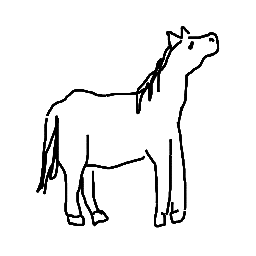

Final Caption

Sample 1: image of horse standing with no outline style drawn by person

Best Caption

Sample 1: image of horse standing near no solid line drawing free icon



In [16]:
# @title Output
Image.open(img_path).show()
print("Final Caption\n")
for i in range(len(FinalCaption)):
    print(f"{FinalCaption[i]}\n")
print("Best Caption\n")
for i in range(len(BestCaption)):
    print(f"{BestCaption[i]}\n")